In [1]:
using Random
using LinearAlgebra: I
using Distributions

include("data_structures.jl");
include("plotting.jl");

In [2]:
"""
    sample_crp_cluster!(n_k, alpha, rng)

Given current cluster counts n_k (length K), sample a cluster index k for a new object
using a CRP(alpha). If k == K+1, this means "start a new cluster".
"""
function sample_crp_cluster!(; n_k::Vector{Int}, alpha::Float64, rng=Random.default_rng())
    K = length(n_k)
    if K == 0
        push!(n_k, 1)
        return 1
    end 
    total = sum(n_k) + alpha
    weights = K == 0 ? [1.0] : [n / total for n in n_k]  # existing clusters
    push!(weights, alpha / total)                        # new cluster option
    k = rand(rng, Categorical(weights))
    if k == K + 1
        push!(n_k, 0)  # initialize count for new cluster
    end
    n_k[k] += 1
    return k
end


sample_crp_cluster!

In [3]:
"""
    sample_category(Ii, O, d, alpha, hyper, rng=Random.default_rng())

Sample one category under the object-aware HDP+,infinity generative model.

Arguments
--------
j     : category label
Ii    : number of objects in the category (adding i to avoid confusion with LinearAlgebra.I)
O     : number of percepts per object (fixed for simplicity)
d     : feature dimension
alpha : CRP concentration (controls number of clusters)
hyper : ObjectAwareHDPHyperparams

Returns
-------
CategorySample with sigma^2, cluster means mu_k, and per-object percept data.
"""
function sample_category(; j::Int, Ii::Int, O::Int, d::Int,
                         alpha::Float64,
                         hyper::ObjectAwareHDPHyperparams,
                         rng = Random.default_rng())

    # 1. Category-specific variance
    if hyper.sigma2 != nothing  # If category variance is provided, use it
        sigma2 = hyper.sigma2
    else                        # If not, we sample from IG(a0, b0)
        sigma2 = rand(rng, InverseGamma(hyper.a0, hyper.b0))
    end

    # 2. Storage for cluster means and counts
    mus = Vector{Vector{Float64}}()  # mu_k
    n_k = Int[]                      # counts per cluster

    # 3. Sample objects
    objects = Vector{ObjectData}(undef, Ii)

    for i in 1:Ii
        # 3a. CRP: choose cluster for object i
        k = sample_crp_cluster!(n_k=n_k, alpha=alpha, rng=rng)

        # If this is a brand-new cluster, sample its mean mu_k
        if k > length(mus)
            sigma_clu = (sigma2 / hyper.k_clu) * I(d)
            mu_k = rand(rng, MvNormal(hyper.m0, sigma_clu))
            push!(mus, mu_k)
        end
        mu_k = mus[k]

        # 3b. Sample object-level mean phi_i given mu_k
        sigma_obj = (sigma2 / hyper.k_obj) * I(d)
        phi_i = rand(rng, MvNormal(mu_k, sigma_obj))

        # 3c. Sample percepts for this object
        sigma_per = (sigma2 / hyper.k_per) * I(d)
        ys_i = Vector{Vector{Float64}}(undef, O)
        for o in 1:O
            ys_i[o] = rand(rng, MvNormal(phi_i, sigma_per))
        end

        objects[i] = ObjectData(j, k, phi_i, ys_i)
    end

    return CategorySample(j, sigma2, mus, objects)
end


sample_category

In [4]:
"""
    build_clusters(cat::CategorySample) -> Vector{ClusterSample}

Reconstruct cluster-level data for a sampled category.

Given a `CategorySample`, this function groups all `ObjectData` objects
according to their cluster labels (`obj.z`) and returns a vector of
`ClusterSample` structs. Each `ClusterSample` contains:

  • the category index `j`
  • the cluster index `k`
  • the cluster mean `mu_k`
  • all objects assigned to that cluster

The resulting vector is sorted by the cluster index `k` (ascending).

Parameters
----------
cat :: CategorySample
    Output of `sample_category` containing category-level variance, cluster
    means, and object-level assignments.

Returns
-------
Vector{ClusterSample}
    One entry per cluster present in the category.
"""
function build_clusters(cat::CategorySample)
    # group objects by cluster index z
    groups = Dict{Int, Vector{ObjectData}}()
    for obj in cat.objects
        push!(get!(groups, obj.z, ObjectData[]), obj)
    end

    clusters = ClusterSample[]
    for (k, objs) in sort(collect(groups); by = first)  # ensure ordered by k
        mu_k = cat.mus[k]
        push!(clusters, ClusterSample(j = cat.j, k = k, mu = mu_k, objects = objs))
    end

    return clusters
end


build_clusters

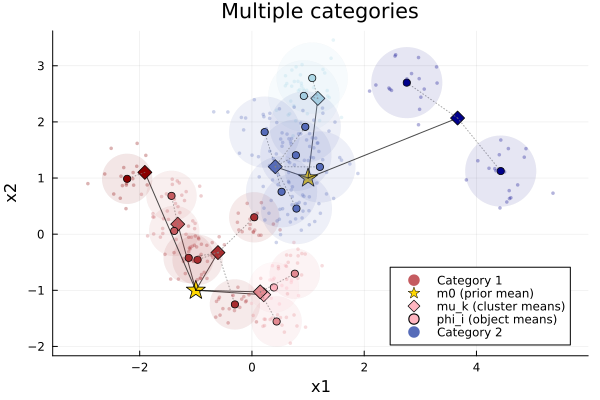

In [5]:
# Dimension & hyperparameters
D = 2
ALPHA = 1.0
Ii = 10         # objects per category
O = 18          # percepts per object

hyper1 = ObjectAwareHDPHyperparams(
    m0     = [-1.0, -1.0], 
    k_clu  = 1.0,
    k_obj  = 5.0,
    k_per  = 20.0,
    sigma2 = 1
)
category1 = sample_category(j=1, Ii=Ii, O=O, d=D, alpha=ALPHA, hyper=hyper1, rng=MersenneTwister(42));

hyper2 = ObjectAwareHDPHyperparams(
    m0     = [1.0, 1.0], 
    k_clu  = 1.0,
    k_obj  = 5.0,
    k_per  = 20.0,
    sigma2 = 2
)
category2 = sample_category(j=2, Ii=Ii, O=O, d=D, alpha=ALPHA, hyper=hyper2, rng=MersenneTwister(56)); # 43, 53, 54, 56

plot_categories([category1, category2], [hyper1, hyper2])

Pseudocode for constructing training/test set

Within each category, 

10 objects & 50 percepts in training
- Skewed: [18, 9, 6, 5, 4, 3, 2, 2, 1]
- Uniform: 5 percepts/objects 

10 objects & 50 percepts in test
- 5 percepts/objects

Use sample_category() to sample 10 objects, each with 18 percepts / category
Construct the sets s.t.
- Each object gets to be the most dominant one
- Each object appears in both training and test
- If an object is not the most dominant one in training / is part of test set, randomly sample the number of percepts needed

Get permutation of object ids 1-20. The first 10 becomes training (with frequency in this order) and the last 10 becomes test.